In [1]:
import json
import os

# disable TF logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from constants import *

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Map inputs to layers

Here, we will use a dictionary of inputs where keys are column names and values are input layers.

### Creating the dataset from CSV

In [3]:
with FEATURE_DESC.open() as f:
    FD = json.load(f)

In [4]:
def dataset_from_file(filename, batch_size, label_name, mappers=[]):
    dataset = tf.data.experimental.make_csv_dataset(
        filename, batch_size, label_name=label_name
    )

    if mappers:
        if not isinstance(mappers, (list, tuple)):
            mappers = [mappers]
        for mapper in mappers:
            dataset = dataset.map(
                mapper, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False
            )
    return dataset.cache()


def stack_mapper(features, label):
    for feat in FD["MH"]:
        fname = feat["name"]
        columns = feat["columns"]
        raw_features = [features.pop(name) for name in columns]
        features[fname] = tf.stack(raw_features, axis=1)
    return features, label

In [5]:
train, val, test = (
    dataset_from_file(str(path), BATCH_SIZE, FD["label"], stack_mapper)
    for path in (DATA_TRAIN, DATA_VAL, DATA_TEST)
)

Metal device set to: AMD Radeon Pro 5300M


## Create input layers

In [6]:
with DATA_VOCAB.open() as f:
    VOCAB = json.load(f)

In [7]:
def get_features():
    DTYPES = {
        "I": tf.int32,
        "S": tf.string,
    }

    features = {}

    for fname in FD["N"]:
        features[fname] = keras.Input(shape=(), name=fname, dtype=tf.float32)

    for dtype, features_desc in FD["C"].items():
        for feature in features_desc:
            fname = feature["name"]
            features[fname] = keras.Input(shape=(), name=fname, dtype=DTYPES[dtype])

    for fname in FD["E"]:
        features[fname] = keras.Input(shape=(), name=fname, dtype=tf.string)

    for feature in FD["MH"]:
        fname = feature["name"]
        columns = feature["columns"]
        features[fname] = keras.Input(
            shape=(len(columns),), name=fname, dtype=tf.float32
        )

    return features

# Deep model

In [8]:
def deep_inputs(features):
    LTYPES = {
        "I": keras.layers.IntegerLookup,
        "S": keras.layers.StringLookup,
    }

    inputs = {}
    for fname in FD["N"]:
        inputs[fname] = tf.expand_dims(features[fname], -1)

    for ltype, features_desc in FD["C"].items():
        for feature in features_desc:
            fname = feature["name"]
            embed = feature["embed"]
            values = VOCAB[fname]
            l = LTYPES[ltype](
                vocabulary=values,
                output_mode="int" if embed else "one_hot",
                mask_token=None,
            )
            if embed:
                l = l(features[fname])
                dim = int(1.6 * (len(values) ** 0.5))
                embedding = keras.layers.Embedding(
                    len(values) + 1,
                    dim,
                )
                l = embedding(l)
            else:
                l = l(tf.expand_dims(features[fname], -1))

            inputs[fname] = l

    for fname in FD["E"]:
        vocab_size = 10000
        sequence_length = 10
        vectorize_layer = keras.layers.TextVectorization(
            max_tokens=vocab_size,
            output_mode="int",
            output_sequence_length=sequence_length,
        )
        l = vectorize_layer(features[fname])

    for feature in FD["MH"]:
        fname = feature["name"]
        embed = feature["embed"]
        if embed:
            in_len = input_dict[col_name].shape[1]
            dim = int(1.6 * (len(in_len) ** 0.5))
            embedding = keras.layers.Dense(
                dim,
                use_bias=False,
            )
            l = embedding(features[fname])
        else:
            l = features[fname]

        inputs[fname] = l

    return keras.layers.concatenate(inputs.values())

In [9]:
def get_model_d():
    features = get_features()
    layer = deep_inputs(features)
    for lsize in DEEP_LSIZE:
        layer = keras.layers.BatchNormalization()(layer)
        layer = keras.layers.Dense(lsize, activation="relu")(layer)
        layer = keras.layers.Dropout(DROPOUT)(layer)

    layer = keras.layers.Dense(1, activation="sigmoid")(layer)
    return keras.Model(inputs=features, outputs=layer, name="D")

Model: "D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MovieID (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 UserID (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 Hour (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Month (InputLayer)             [(None,)]            0           []                               
                                                                                                  

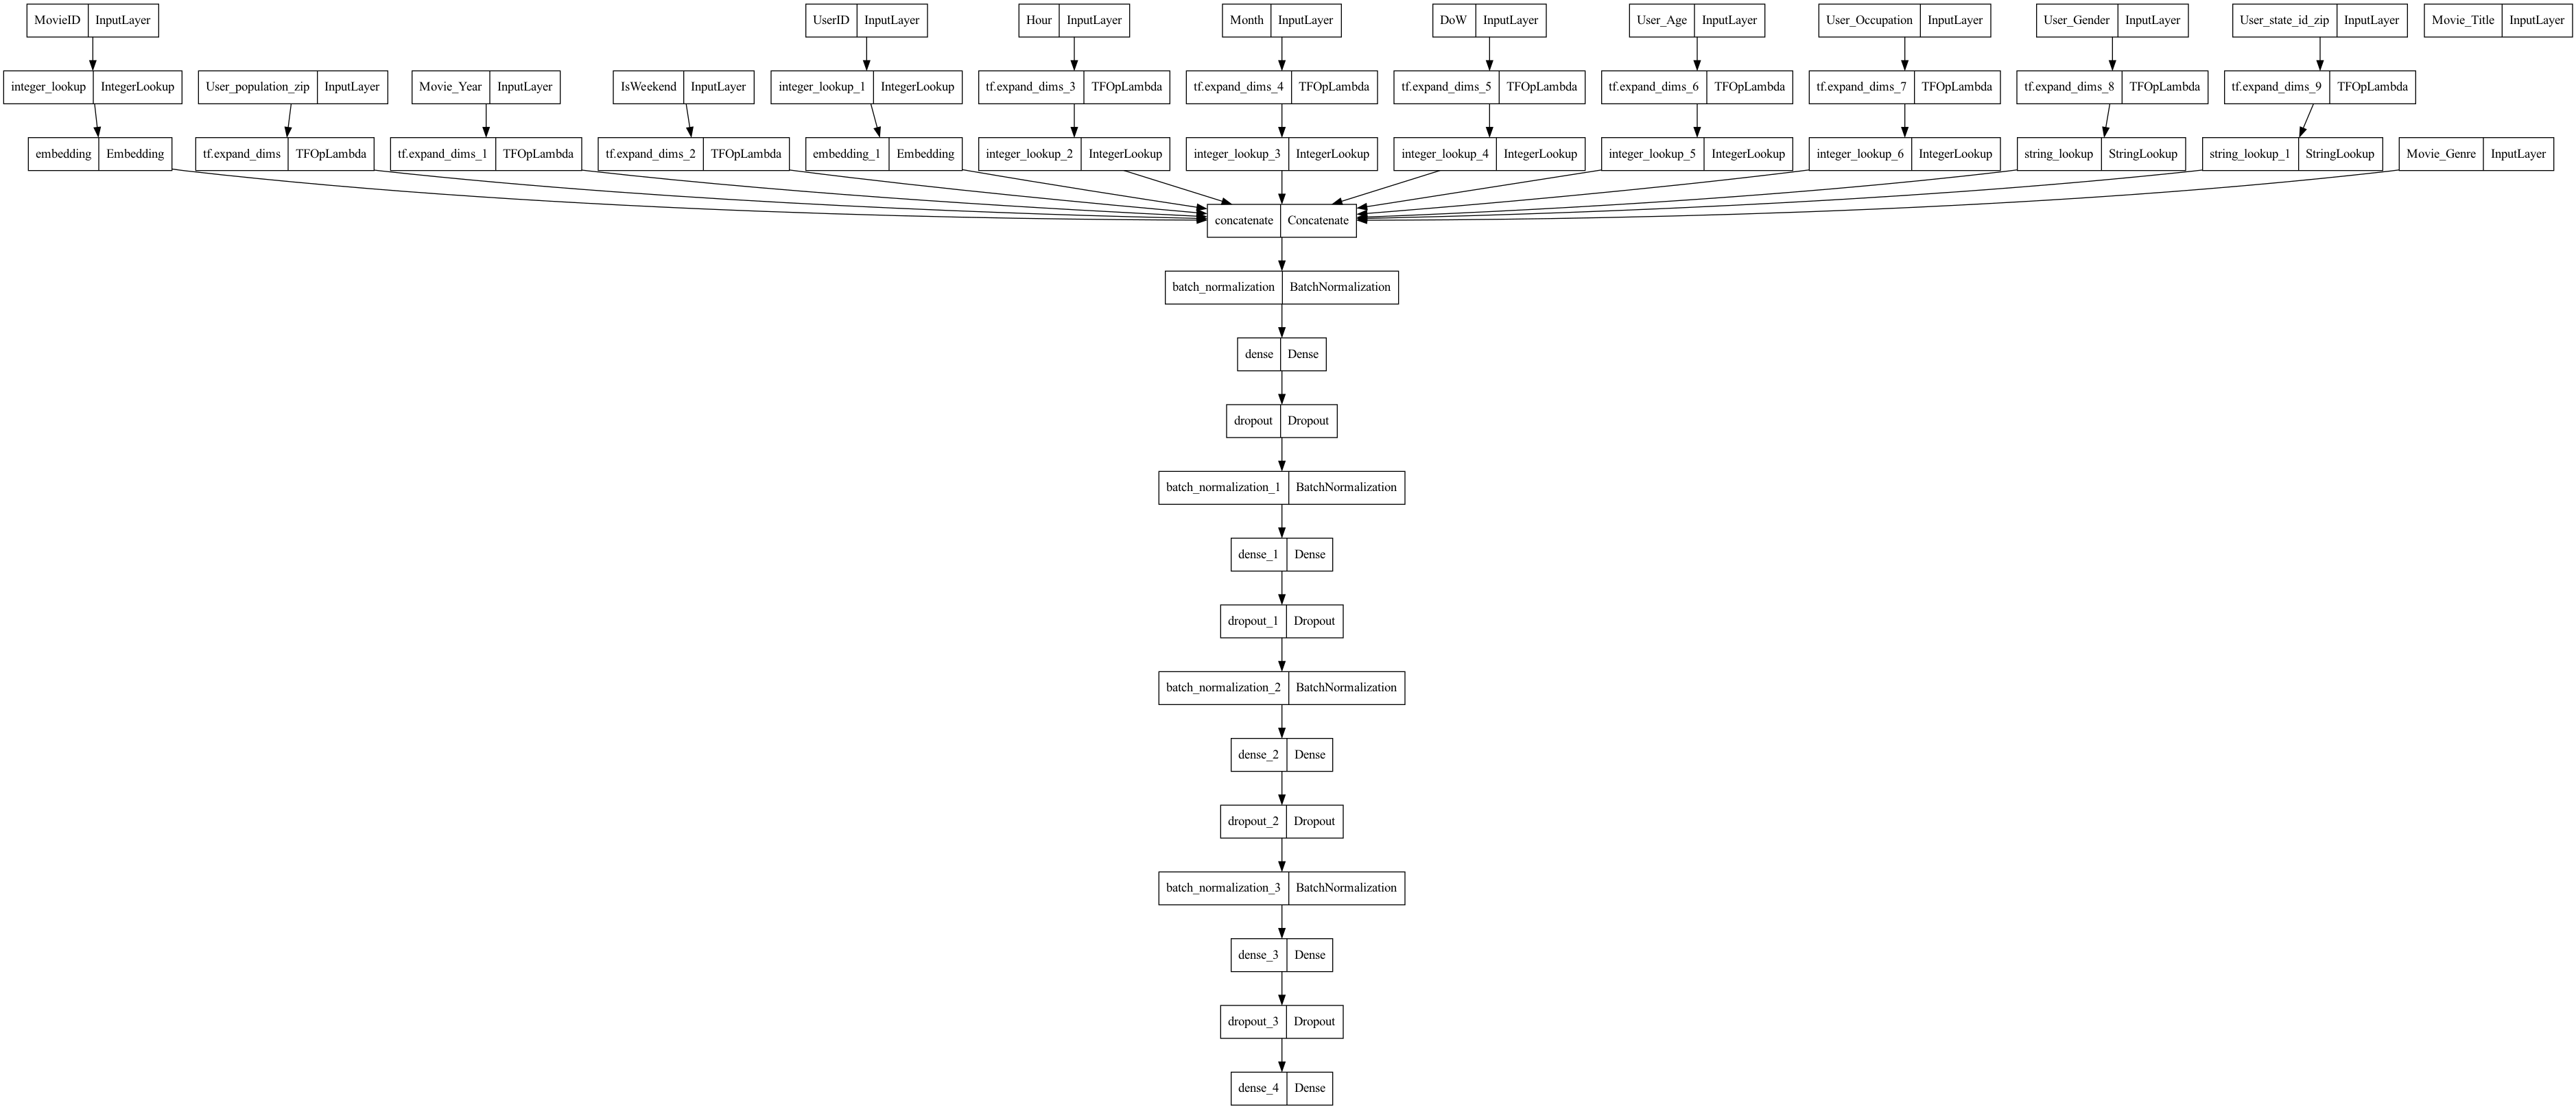

In [10]:
model_d = get_model_d()
model_d.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)
model_d.summary()
keras.utils.plot_model(model_d, to_file=DEEP_IMG_PATH)

In [11]:
with tf.device("/GPU:0"):
    model_d.fit(
        train,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_EPOCH,
        validation_data=val,
        validation_steps=VAL_STEPS,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )
        ],
        workers=WORKERS,
    )

Epoch 1/20
2048/2048 [==============================] - 184s 88ms/step - loss: 0.6105 - binary_accuracy: 0.6732 - auc: 0.7180 - val_loss: 0.6326 - val_binary_accuracy: 0.6509 - val_auc: 0.6840
Epoch 2/20
2048/2048 [==============================] - 171s 84ms/step - loss: 0.5780 - binary_accuracy: 0.7023 - auc: 0.7452 - val_loss: 0.6161 - val_binary_accuracy: 0.6626 - val_auc: 0.7086
Epoch 3/20
2048/2048 [==============================] - 167s 82ms/step - loss: 0.5657 - binary_accuracy: 0.7090 - auc: 0.7604 - val_loss: 0.6008 - val_binary_accuracy: 0.6772 - val_auc: 0.7190
Epoch 4/20
2048/2048 [==============================] - 168s 82ms/step - loss: 0.5631 - binary_accuracy: 0.7113 - auc: 0.7724 - val_loss: 0.5952 - val_binary_accuracy: 0.6899 - val_auc: 0.7313
Epoch 5/20
2048/2048 [==============================] - 169s 82ms/step - loss: 0.5552 - binary_accuracy: 0.7137 - auc: 0.7819 - val_loss: 0.6058 - val_binary_accuracy: 0.6665 - val_auc: 0.7278
Epoch 6/20
2048/2048 [=============

In [12]:
model_d.save(DEEP_MODEL_PATH)

INFO:tensorflow:Assets written to: models/deep.tf/assets


INFO:tensorflow:Assets written to: models/deep.tf/assets


In [ ]:
with tf.device("/CPU:0"):
    model_d.evaluate(test, workers=WORKERS)

 549287/Unknown - 10789s 20ms/step - loss: 0.8703 - binary_accuracy: 0.6510 - auc: 0.6881

# Wide model

TBD